<a href="https://colab.research.google.com/github/clifford-cheng/Lending-Club/blob/master/LendingClub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import os
from tqdm import tqdm
import string
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report as report

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from imblearn.over_sampling import SMOTE

from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer, confusion_matrix, plot_confusion_matrix
import xgboost as xgb
from xgboost import cv

import re
import nltk
from nltk.corpus import stopwords

import pickle


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
def get_file_list(directory):
    file_list = []
    for filename in sorted(os.listdir(directory)):
        if filename.endswith('.csv'):
            file_list.append(filename)
    return file_list

def p2f(x):
    return float(x.strip('%'))/100

f = lambda x: float(x.strip('%'))/100
s = lambda x: int(x[4:])
g = lambda x: int(x[1:])
def loan(x):
  if x < 10000:
    return 1
  elif 10000 <= x < 20000:
    return 2
  elif 20000 <= x < 30000:
    return 3
  else:
    return 4

def convert_date(x):
  x = int(x[4:])
  return x

def dummy(dataframe):
  dataframe = pd.get_dummies(dataframe, columns=['term', 'application_type'], drop_first=False)
  dataframe = pd.get_dummies(dataframe, columns=['home_ownership', 'addr_state', 'purpose', 'grade', 'emp_title'], drop_first=True)
  return dataframe

def dummy_no_grade(dataframe):
  dataframe = pd.get_dummies(dataframe, columns=['term', 'application_type'], drop_first=False)
  dataframe2 = pd.get_dummies(dataframe, columns=['home_ownership', 'addr_state', 'purpose'], drop_first=True)
  return dataframe2

def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, ' ')
    return text



def get_returns(df, model, year, grade=None):
  df_raw = df
  df_raw = df[df['grade']==grade]
  df_raw = df_raw[df_raw['issue_d']>=year]

  df_extracted = extract_features(df_raw)
  predict_array = model.predict(df_extracted)
  mask = (predict_array == 1)
  returns_df = df_raw[mask]

  returns = returns_df['total_pymnt_inv'].sum()/returns_df['loan_amnt'].sum()
  return returns


def consol_df(directory):
    dataframe = pd.DataFrame(columns = ['id', 'issue_d', 'loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'emp_title', 'purpose', 
                                        'emp_length', 'home_ownership', 'sub_grade',
          'annual_inc', 'verification_status', 'loan_status', 'tot_cur_bal', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_low', 
          'inq_last_6mths', 'pub_rec', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
          'recoveries', 'collection_recovery_fee', 'application_type', 'open_acc_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il',
          'open_rv_12m', 'open_rv_24m', 'inq_fi', 'inq_last_12m', 'acc_open_past_24mths'])
    df_list = get_file_list(directory)
    for i in tqdm(df_list):    
        df = pd.read_csv('/content/drive/My Drive/Galvanize/Capstones/capstone_3/data/'+ i, header=1, engine='python', 
                            dtype={'id': int, 'desc': str, 'next_pymnt_d': str, 'verification_status_joint':str, 'verification_status': str, 
                                   },
                            skipfooter=4)
        df = df[['id', 'issue_d', 'loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'emp_title', 'purpose', 'emp_length', 'home_ownership', 'sub_grade',
          'annual_inc', 'verification_status', 'loan_status', 'tot_cur_bal', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_low', 
          'inq_last_6mths', 'pub_rec', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
          'recoveries', 'collection_recovery_fee', 'application_type', 'open_acc_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il',
          'open_rv_12m', 'open_rv_24m', 'inq_fi', 'inq_last_12m', 'acc_open_past_24mths']]
        # Only get loans that defaulted or were fully paid.
        df = df[df['loan_status'].isin(('Charged Off', 'Fully Paid'))]

        #df = df[df['application_type']=='Individual']

        # Get only mortgage, owned, or rented.
        df = df[df['home_ownership'].isin(['MORTGAGE', 'OWN', 'RENT'])]

        # Data cleaning.
        df['term'] = df['term'].replace(' ', '')
        df['int_rate'] = df['int_rate'].map(f)
        df['issue_d'] = df['issue_d'].map(s)
        df['earliest_cr_line'] = df['earliest_cr_line'].map(s)
        df['sub_grade'] = df['sub_grade'].map(g)

        df['inq_last_6mths'] = df['inq_last_6mths'].fillna(0).astype(int)
        df['loan_status'] = df['loan_status'].map({'Fully Paid': 1, 'Charged Off': 0})
        df['verification_status'] = df['verification_status'].map({'Verified': 1, 'Source Verified':1, 'Not Verified': 0})
        df['emp_title'] = df['emp_title'].fillna('None')
        df['emp_length'] = df['emp_length'].map({'3 years': 3, '10+ years':10, '4 years':4, '2 years':2, '5 years':5, 
                              '6 years': 6,'1 year': 1, '7 years': 7, '< 1 year': 1, '9 years': 9, '8 years':0, '0':0})
        df[['delinq_2yrs', 'fico_range_low', 'inq_last_6mths', 'pub_rec']] = df[['delinq_2yrs', 'fico_range_low', 'inq_last_6mths', 'pub_rec']].astype(int)
        df['earliest_cr_line'] = df['issue_d'] - df['earliest_cr_line'].astype(int)
        df = df.fillna(0)
        dataframe = pd.concat([dataframe, df], axis = 0)
    
    #dataframe = dataframe.drop(columns='application_type', axis = 0)

    dataframe = dataframe.reset_index(drop=True)
    return dataframe


In [ ]:
df = consol_df("/content/drive/My Drive/Galvanize/Capstones/capstone_3/data")





  0%|          | 0/15 [00:00<?, ?it/s]


  7%|▋         | 1/15 [00:21<04:59, 21.36s/it]


 13%|█▎        | 2/15 [00:46<04:52, 22.48s/it]


 20%|██        | 3/15 [01:32<05:53, 29.43s/it]


 27%|██▋       | 4/15 [01:48<04:39, 25.40s/it]


 33%|███▎      | 5/15 [02:00<03:34, 21.41s/it]


 40%|████      | 6/15 [02:12<02:48, 18.68s/it]


 47%|████▋     | 7/15 [02:26<02:17, 17.17s/it]


 53%|█████▎    | 8/15 [02:38<01:49, 15.71s/it]


 60%|██████    | 9/15 [02:51<01:29, 14.99s/it]


 67%|██████▋   | 10/15 [03:07<01:15, 15.19s/it]


 73%|███████▎  | 11/15 [03:22<01:00, 15.17s/it]


 80%|████████  | 12/15 [03:36<00:44, 14.75s/it]


 87%|████████▋ | 13/15 [03:52<00:30, 15.23s/it]


 93%|█████████▎| 14/15 [04:09<00:15, 15.59s/it]


100%|██████████| 15/15 [04:25<00:00, 17.70s/it]


In [ ]:
# Saves extracted and cleaned data to csv.
df.to_csv('/content/drive/My Drive/Galvanize/Capstones/capstone_3/lending_club_data.csv', index=False)

In [4]:
# Retrieves saved csv data.
df = pd.read_csv('/content/drive/My Drive/Galvanize/Capstones/capstone_3/lending_club_data.csv')

In [14]:
# Retrieves and cleans job title dataset from BLS.
corpus = pd.read_excel('/content/drive/My Drive/Galvanize/Capstones/capstone_3/soc_2018_direct_match_title_file.xlsx', 
                       header=7)
corpus = corpus.drop(columns=['2018 SOC Code', 'Illustrative Example'])
corpus['2018 SOC Direct Match Title'] = corpus['2018 SOC Direct Match Title'].str.lower().apply(remove_punctuations)

In [93]:
df

,id,issue_d,loan_amnt,term,int_rate,installment,grade,emp_title,purpose,emp_length,home_ownership,sub_grade,annual_inc,verification_status,loan_status,tot_cur_bal,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,inq_last_6mths,pub_rec,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,application_type,open_acc_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,open_rv_12m,open_rv_24m,inq_fi,inq_last_12m,acc_open_past_24mths
0,10148122,2013,12000,36 months,0.0762,373.94,A,Systems Engineer,debt_consolidation,3.0,MORTGAGE,3,96500.0,0,1,200314.0,TX,12.61,0,10,705,0,0,13397.54,12000.00,1397.54,0.0,0.0,0.0,Individual,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
1,10149342,2013,27050,36 months,0.1099,885.46,B,Team Leadern Customer Ops & Systems,debt_consolidation,10.0,OWN,2,55000.0,1,1,114834.0,MI,22.87,0,27,730,0,0,31752.53,27050.00,4702.53,0.0,0.0,0.0,Individual,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
2,10129454,2013,12000,36 months,0.1099,392.81,B,Project Manager,debt_consolidation,4.0,RENT,2,60000.0,0,1,7137.0,NC,4.62,0,4,720,1,0,13988.61,12000.00,1988.61,0.0,0.0,0.0,Individual,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
3,10149488,2013,4800,36 months,0.1099,157.13,B,Surgical Technician,home_improvement,2.0,MORTGAGE,2,39600.0,1,1,4136.0,TX,2.49,0,18,755,2,0,5157.52,4800.00,357.52,0.0,0.0,0.0,Individual,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10129477,2013,14000,36 months,0.1285,470.71,B,Assistant Director - Human Resources,debt_consolidation,4.0,RENT,4,88000.0,0,1,17672.0,NC,10.02,1,25,670,0,1,16945.32,14000.00,2945.32,0.0,0.0,0.0,Individual,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1816212,140711050,2018,24000,60 months,0.1502,571.22,C,Instructional Technology Specialist,debt_consolidation,10.0,MORTGAGE,3,60000.0,0,1,214535.0,TX,9.72,0,19,685,1,0,27637.21,24000.00,3637.21,0.0,0.0,0.0,Individual,1.0,0.0,0.0,18.0,2.0,3.0,0.0,3.0,4.0
1816213,140712720,2018,20000,60 months,0.1502,476.01,C,Technical Supvervisor,credit_card,10.0,MORTGAGE,3,75000.0,1,1,285451.0,TX,24.82,0,27,665,2,0,22186.60,20000.00,2186.60,0.0,0.0,0.0,Individual,3.0,1.0,1.0,3.0,1.0,1.0,0.0,3.0,5.0
1816214,140346789,2018,5000,36 months,0.1614,176.14,C,None,debt_consolidation,0.0,OWN,4,9200.0,1,1,3258.0,AL,23.50,0,3,705,1,0,6045.90,5000.00,1045.90,0.0,0.0,0.0,Individual,0.0,0.0,0.0,29.0,3.0,6.0,1.0,2.0,6.0
1816215,140557520,2018,5000,36 months,0.1614,176.14,C,Oncology Medical Assistant,debt_consolidation,3.0,MORTGAGE,4,46400.0,1,1,140818.0,FL,16.85,0,15,665,0,0,5436.03,5000.00,436.03,0.0,0.0,0.0,Individual,0.0,1.0,1.0,10.0,1.0,5.0,2.0,5.0,6.0


In [ ]:
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

glove_file = datapath('/content/drive/My Drive/Galvanize/Capstones/capstone_3/glove.6B.300d.txt')
word2vec_glove_file = get_tmpfile("glove.6B.300d.word2vec.txt")
glove2word2vec(glove_file, word2vec_glove_file)
model = KeyedVectors.load_word2vec_format(word2vec_glove_file)


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
def analogy(x1, x2, y1):
    result = model.most_similar(positive=[y1, x2], negative=[x1])
    return result[0][0]
analogy('software', 'data', 'system')


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


'systems'

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
my_stop_words = ['general']
def top_latent(df, components):
  tfidf_vect = TfidfVectorizer(max_df=0.8, min_df=0, stop_words=my_stop_words, 
                                lowercase=True, ngram_range=(1,2), strip_accents = "ascii",
                                tokenizer=None)

  doc_term_matrix = tfidf_vect.fit_transform(df['emp_title'].values)   
  nmf = NMF(n_components=components, random_state=42)
  nmf.fit(doc_term_matrix )

  topic_values = nmf.transform(doc_term_matrix)
  df['emp_title'] = topic_values.argmax(axis=1)
  for i,topic in enumerate(nmf.components_):
      print(f'Top 10 words for topic #{i}:')
      print([tfidf_vect.get_feature_names()[i] for i in topic.argsort()[-10:]])
      print('\n')
  return df

In [21]:
df = top_latent(df, 35)


Top 10 words for topic #0:
['f117', 'eztransition', 'ezexutive assistant', 'ezexutive', 'eze castle', 'eze', 'ezcorp online', 'f117 lpm', 'zytron control', 'none']


Top 10 words for topic #1:
['district manager', 'account manager', 'program', 'service manager', 'program manager', 'branch', 'branch manager', 'assistant manager', 'sales manager', 'manager']


Top 10 words for topic #2:
['lead teacher', 'substitute teacher', 'education', 'special', 'special education', 'education teacher', 'teacher assistant', 'coach', 'teacher coach', 'teacher']


Top 10 words for topic #3:
['stylist', 'broker', 'manager owner', 'president owner', 'owner president', 'owner manager', 'co', 'co owner', 'owner operator', 'owner']


Top 10 words for topic #4:
['cdl driver', 'school bus', 'cdl', 'forklift', 'forklift driver', 'delivery', 'delivery driver', 'bus', 'bus driver', 'driver']


Top 10 words for topic #5:
['regional sales', 'of sales', 'sales consultant', 'representative', 'rep', 'sales representat

In [41]:
map_dict = {0: 'Unknown', 1: 'Manager', 2: 'Teacher', 3: 'Owner', 4: 'Bus/Machine Operator', 5: 'Sales', 
            6: 'Nurse', 7: 'Supervisor', 8: 'Nurse Supervisor', 9: 'Director', 
            10: 'Executive', 11: 'Software Engineer', 12: 'Project Manager', 13: 'Assistant', 14: 'HR', 
            15: 'Lab Technician', 16: 'Analyst', 17: 'Customer Service', 18: 'Officer', 
            19: 'Operations', 20: 'Bus/Machine Operator', 21: 'Accountant', 22: 'Account Manager', 
            23: 'Truck Operator', 24: 'Mechanic', 25: 'Retail Store Manager', 26: 'Attorney', 27: 'Consultant', 
            28: 'HR', 29: 'Pharmacy Tech', 30: 'Associate', 31: 'IT Specialist', 32: 'Maintenance Worker', 
            33: 'Network Admin', 34: 'Food/Drink Server'} 

df['emp_title'] = df['emp_title'].map(map_dict)

In [92]:
def train_test(df, grade, year):
    df_grade = df[df['grade']==grade]
    df_grade = df_grade.drop(columns='grade', axis = 0)
    df_grade = dummy_no_grade(df_grade)

    df_model_train = df_grade[df_grade['issue_d']<year]
    df_model_test = df_grade[df_grade['issue_d'] >= year]

    df_model_train = df_model_train.drop(columns= ['issue_d', 'id', 'int_rate','installment', 'loan_amnt',
                                      'total_pymnt_inv', 'total_rec_prncp','total_rec_int', 'total_rec_late_fee',
                                      'recoveries', 'collection_recovery_fee', 'verification_status' 
                                      ], axis = 0)
    df_model_test = df_model_test.drop(columns= ['issue_d', 'id', 'int_rate','installment', 'loan_amnt',
                                      'total_pymnt_inv', 'total_rec_prncp','total_rec_int', 'total_rec_late_fee',
                                      'recoveries', 'collection_recovery_fee', 'verification_status'
                                      ], axis = 0)

    # df_model_train make balanced.
    df_class_0 = df_model_train[df_model_train['loan_status']==0]
    df_class_1 = df_model_train[df_model_train['loan_status']==1]

    n = len(df_class_1)

    df_class_0_sub = df_class_0.sample(n, replace=True)
    df_class_1_sub = df_class_1.sample(n, replace=False)
    df_balanced = pd.concat([df_class_0_sub, df_class_1_sub], axis=0)
    df_balanced = df_balanced.sample(frac=1).reset_index(drop=True)
    
    X_bal = df_balanced.drop(columns='loan_status')
    y_bal = df_balanced['loan_status'].astype(int)
    X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size = .25)
    
    X_remain = df_model_test.drop(columns='loan_status')
    y_remain = df_model_test['loan_status'].astype(int)
    return X_train, X_test, y_train, y_test, X_remain, y_remain

def returns(df, model, year, grade):  
  df_raw = df[df['grade']==grade]
  df_raw = df_raw.drop(columns='grade', axis = 0)

  df_raw = dummy_no_grade(df_raw)

  df_raw = df_raw[df_raw['issue_d']>=year]

  df_features = df_raw.drop(columns= ['issue_d', 'loan_status', 'id', 'int_rate','installment', 'loan_amnt',
                                        'total_pymnt_inv', 'total_rec_prncp','total_rec_int', 'total_rec_late_fee',
                                        'recoveries', 'collection_recovery_fee', 'verification_status' 
                                        ], axis = 0)
  predicted_array = model.predict(df_features)
  mask = (predicted_array ==1)
  returns_df = df_raw[mask]

  returns = returns_df['total_pymnt_inv'].sum()/returns_df['loan_amnt'].sum()
  print(returns_df['loan_amnt'].sum())
  print(returns)
  print(report(df_raw['loan_status'], predicted_array))

  return returns

In [74]:
X_train, X_test, y_train, y_test, X_remain, y_remain = train_test(df, 'G', 2017)
X_train

,emp_length,sub_grade,annual_inc,tot_cur_bal,dti,delinq_2yrs,earliest_cr_line,fico_range_low,inq_last_6mths,pub_rec,open_acc_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,open_rv_12m,open_rv_24m,inq_fi,inq_last_12m,acc_open_past_24mths,term_ 36 months,term_ 60 months,application_type_Individual,application_type_Joint App,home_ownership_OWN,home_ownership_RENT,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,...,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,emp_title_Accountant,emp_title_Analyst,emp_title_Assistant,emp_title_Associate,emp_title_Attorney,emp_title_Bus/Machine Operator,emp_title_Consultant,emp_title_Customer Service,emp_title_Director,emp_title_Executive,emp_title_Food/Drink Server,emp_title_HR,emp_title_IT Specialist,emp_title_Lab Technician,emp_title_Maintenance Worker,emp_title_Manager,emp_title_Mechanic,emp_title_Network Admin,emp_title_Nurse,emp_title_Nurse Supervisor,emp_title_Officer,emp_title_Operations,emp_title_Owner,emp_title_Pharmacy Tech,emp_title_Project Manager,emp_title_Retail Store Manager,emp_title_Sales,emp_title_Software Engineer,emp_title_Supervisor,emp_title_Teacher,emp_title_Truck Operator,emp_title_Unknown
6037,2.0,4,65000.00,228106.0,19.28,1,10,700,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4845,5.0,4,42000.00,48083.0,12.63,0,16,700,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7013,1.0,1,114470.00,39712.0,15.68,0,15,665,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4887,9.0,3,86200.00,292220.0,20.23,0,11,685,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5890,10.0,1,130000.00,419089.0,16.98,1,23,670,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1844,10.0,3,90000.00,40503.0,14.59,0,16,660,2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1773,10.0,4,50000.00,15476.0,10.94,0,20,660,4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1115,0.0,3,28920.00,150157.0,10.66,0,18,675,2,0,3.0,0.0,2.0,20.0,4.0,8.0,1.0,3.0,12.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2405,10.0,1,55000.00,17435.0,16.89,7,17,660,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [98]:
returns(df, dumb_model, 2017, 'A')

882484150
              precision    recall  f1-score   support

           0       0.07      0.50      0.13      9269
           1       0.93      0.50      0.65    114843

    accuracy                           0.50    124112
   macro avg       0.50      0.50      0.39    124112
weighted avg       0.86      0.50      0.61    124112



1.0246360743249612

In [11]:
#XGB 
returns(df, model, 2017, 'A')

1724247125
              precision    recall  f1-score   support

           0       0.15      0.05      0.08      9269
           1       0.93      0.98      0.95    114843

    accuracy                           0.91    124112
   macro avg       0.54      0.52      0.52    124112
weighted avg       0.87      0.91      0.89    124112



1.0262900663557726

In [37]:
#GB
returns(df, model, 2017, 'A')

1105211625
              precision    recall  f1-score   support

           0       0.11      0.61      0.19      9269
           1       0.95      0.60      0.74    114843

    accuracy                           0.60    124112
   macro avg       0.53      0.61      0.46    124112
weighted avg       0.89      0.60      0.70    124112



1.0379588595532552

In [76]:
#GB with NMF
returns(df, model, 2017, 'G')

29993450
0.9123938990012819
              precision    recall  f1-score   support

           0       0.55      0.62      0.58      1691
           1       0.55      0.47      0.51      1632

    accuracy                           0.55      3323
   macro avg       0.55      0.55      0.54      3323
weighted avg       0.55      0.55      0.55      3323



0.9123938990012819

In [58]:
df_test = df[df['grade']=='D']
df_test = df_test[df_test['issue_d']>=2017]
#df_test = df_test[df_test['loan_status']==0]

#df_test['int_rate'].mean()
df_test['total_pymnt_inv'].sum()/df_test['loan_amnt'].sum()

0.971359164179382

In [25]:

# Dumb Model
from sklearn.dummy import DummyClassifier

dumb_model = DummyClassifier(strategy='stratified')
dumb_model.fit(X_train, y_train)
y_pred = dumb_model.predict(X_test)
y_full_pred = dumb_model.predict(X_remain)
print(report(y_test, y_pred))
print(report(y_remain, y_full_pred))

              precision    recall  f1-score   support

           0       0.50      0.50      0.50     48670
           1       0.50      0.50      0.50     49049

    accuracy                           0.50     97719
   macro avg       0.50      0.50      0.50     97719
weighted avg       0.50      0.50      0.50     97719

              precision    recall  f1-score   support

           0       0.07      0.50      0.13      9269
           1       0.93      0.50      0.65    114843

    accuracy                           0.50    124112
   macro avg       0.50      0.50      0.39    124112
weighted avg       0.86      0.50      0.61    124112



In [75]:
# GB
model = GradientBoostingClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_full_pred = model.predict(X_remain)
print(report(y_test, y_pred))
print(report(y_remain, y_full_pred))

              precision    recall  f1-score   support

           0       0.58      0.58      0.58       947
           1       0.57      0.57      0.57       925

    accuracy                           0.58      1872
   macro avg       0.58      0.58      0.58      1872
weighted avg       0.58      0.58      0.58      1872

              precision    recall  f1-score   support

           0       0.55      0.62      0.58      1691
           1       0.55      0.47      0.51      1632

    accuracy                           0.55      3323
   macro avg       0.55      0.55      0.54      3323
weighted avg       0.55      0.55      0.55      3323



In [10]:
import re
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

model = XGBClassifier(
objective='binary:logistic', gamma = 1,
                            seed=42,
                           learn_rate = .15,
                           max_depth = 10,
                           reg_lambda = 0,
                           scale_pos_weight=2,
                           subsample=.9,
                           colsample_bytree=0.5)

eval_set = [(X_test, y_test)]
model.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="error", eval_set=eval_set, verbose=False )

#y_pred = model.predict(X_test)
y_full_pred = model.predict(X_remain)

#print(report(y_test, y_pred))
print(report(y_remain, y_full_pred))

              precision    recall  f1-score   support

           0       0.15      0.05      0.08      9269
           1       0.93      0.98      0.95    114843

    accuracy                           0.91    124112
   macro avg       0.54      0.52      0.52    124112
weighted avg       0.87      0.91      0.89    124112



Text(0.5, 1.0, 'Profit Curve')

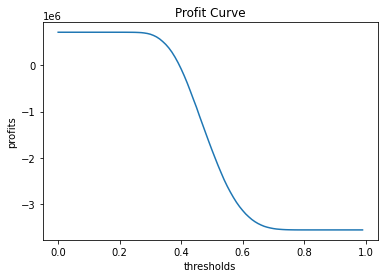

In [17]:
def predict(model, X, threshold=0.5):
    '''Return prediction of the fitted binary-classifier model model on X using
    the specifed `threshold`. NB: class 0 is the positive class'''
    return np.where(model.predict_proba(X)[:, 0] > threshold,
                    model.classes_[0],
                    model.classes_[1])

def confusion_matrix(model, X, threshold=0.5):
    cf = pd.crosstab(y_test, predict(model, X_test, threshold))
    cf = cf.add(pd.DataFrame([[0,0],[0,0]]), fill_value=0)
    #, columns=['Fraud', 'Not'], index=['Fraud', 'Not']
    # cf.index.name = 'actual'
    # cf.columns.name = 'predicted'
    return cf

def calculate_payout(cb_matrix, model, X, threshold):
  return (confusion_matrix(model, X, threshold) * cb_matrix).values.sum()

thresholds = np.arange(0.0, 1.0, 0.01)
profits = []
for threshold in thresholds:
    profits.append(calculate_payout(A_profit, model, X_remain, threshold))

fig, ax = plt.subplots()
ax.plot(thresholds, profits)
ax.set_xlabel('thresholds')
ax.set_ylabel('profits')
ax.set_title('Profit Curve')

In [20]:
thresholds = np.arange(0.0, 1.0, 0.05)
for threshold in thresholds:
    print(calculate_payout(A_profit, model, X_remain, threshold))

713705.8926
713176.3436000001
709257.6810000001
692947.5718
639727.8973000001
512371.3628
240342.04150000005
-223913.5667999999
-843644.7614999998
-1560442.2878999999
-2229527.4494000003
-2792438.0363999996
-3181497.6867
-3403166.8981
-3505899.4041
-3543444.4281999995
-3555200.4159999997
-3556683.1531999996
-3556683.1531999996
-3556683.1531999996


In [16]:
A_profit = np.array([[0, 0],
                     [8.8503, -44.1046]])
B_profit = np.array([[0, -42.6629],
                     [14.2734, 0]])
C_profit = np.array([[0, -42.5045],
                     [19.9549, 0]])
D_profit = np.array([[0, -42.2966],
                     [25.6832, 0]])
E_profit = np.array([[0, -40.346],
                     [32.3826, 0]])
F_profit = np.array([[0, -40.027],
                     [37.5743, 0]])
G_profit = np.array([[0, -42.9726],
                     [37.8152, 0]])

In [77]:
filename = '/content/drive/My Drive/Galvanize/Capstones/capstone_3/gbmodel_nmf_G.sav'
pickle.dump(model, open(filename, 'wb'))

In [36]:
model = pickle.load(open(filename, 'rb'))
y_full_pred = model.predict(X_remain)
print(report(y_remain, y_full_pred))

              precision    recall  f1-score   support

           0       0.51      0.95      0.67      1691
           1       0.58      0.07      0.12      1632

    accuracy                           0.52      3323
   macro avg       0.54      0.51      0.40      3323
weighted avg       0.54      0.52      0.40      3323



In [81]:
#With NMF
model_list = ['gbmodel_nmf_A.sav', 'gbmodel_nmf_B.sav', 'gbmodel_nmf_C.sav', 
              'gbmodel_nmf_D.sav', 'gbmodel_nmf_E.sav', 'gbmodel_nmf_F.sav', 'gbmodel_nmf_G.sav']
grade = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
 
for i in range(len(model_list)):
  filename = '/content/drive/My Drive/Galvanize/Capstones/capstone_3/' + model_list[i]
  model = pickle.load(open(filename, 'rb'))
  X_train, X_test, y_train, y_test, X_remain, y_remain = train_test(df, grade[i], 2017)
  
  df_test = df[df['grade']==grade[i]]
  df_test = df_test[df_test['issue_d']>=2017]

  all_loan_returns = df_test['total_pymnt_inv'].sum()/df_test['loan_amnt'].sum()

  print(f"Grade: {grade[i]} Total: {all_loan_returns}")
  returns(df, model, 2017, grade[i])


Grade: A Total: 1.02490108612085
1113533675
1.0388532788108094
              precision    recall  f1-score   support

           0       0.11      0.62      0.19      9269
           1       0.95      0.61      0.74    114843

    accuracy                           0.61    124112
   macro avg       0.53      0.61      0.47    124112
weighted avg       0.89      0.61      0.70    124112

Grade: B Total: 1.0055859406494465
1231850700
1.0373051509326576
              precision    recall  f1-score   support

           0       0.20      0.61      0.31     26444
           1       0.88      0.55      0.68    141848

    accuracy                           0.56    168292
   macro avg       0.54      0.58      0.49    168292
weighted avg       0.78      0.56      0.62    168292

Grade: C Total: 0.971359164179382
1155818650
1.0219495664047298
              precision    recall  f1-score   support

           0       0.32      0.64      0.42     42593
           1       0.81      0.53      0.64  

In [90]:
#No NMF
model_list = ['gbmodelA.sav', 'gbmodelB.sav', 'gbmodelC.sav', 
              'gbmodelD.sav', 'gbmodelE.sav', 'gbmodelF.sav', 'gbmodelG.sav']
grade = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
 
for i in range(len(model_list)):
  filename = '/content/drive/My Drive/Galvanize/Capstones/capstone_3/' + model_list[i]
  model = pickle.load(open(filename, 'rb'))
  X_train, X_test, y_train, y_test, X_remain, y_remain = train_test(df, grade[i], 2017)
  
  df_test = df[df['grade']==grade[i]]
  df_test = df_test[df_test['issue_d']>=2017]
  
  all_loan_returns = df_test['total_pymnt_inv'].sum()/df_test['loan_amnt'].sum()

  print(f"Grade: {grade[i]} Total: {all_loan_returns}")
  returns(df, model, 2017, grade[i])


Grade: A Total: 1.02490108612085
1105211625
1.0379588595532552
              precision    recall  f1-score   support

           0       0.11      0.61      0.19      9269
           1       0.95      0.60      0.74    114843

    accuracy                           0.60    124112
   macro avg       0.53      0.61      0.46    124112
weighted avg       0.89      0.60      0.70    124112

Grade: B Total: 1.0055859406494465
1239048925
1.03412548869287
              precision    recall  f1-score   support

           0       0.20      0.60      0.30     26444
           1       0.88      0.55      0.68    141848

    accuracy                           0.56    168292
   macro avg       0.54      0.58      0.49    168292
weighted avg       0.77      0.56      0.62    168292

Grade: C Total: 0.971359164179382
1445211900
1.0045763885489731
              precision    recall  f1-score   support

           0       0.32      0.51      0.39     42593
           1       0.79      0.63      0.70    

In [101]:
#ROUND 1
param_grid = {'max_depth': [3, 5,10],
                      'learning_rate': [0.1, 0.15],
                      'gamma': [.25,1.0],
                      'reg_lambda': [0,1.0],
                    'scale_pos_weight': [0,.5,1,2] }

# best parameters: {'gamma': 1.0, 'learning_rate': 0.1, 
# 'max_depth': 5, 'reg_lambda': 0, 'scale_pos_weight': 1}

# ROUND 2
# param_grid = {'max_depth': [5, 7, 10],
#                       'learning_rate': [0.1, 0.15],
#                       'gamma': [0,.25],
#                       'reg_lambda': [0],
#                     'scale_pos_weight': [.5, 1]}

# # best parameters: {'gamma': 0, 'learning_rate': 0.15, 'max_depth': 10, 'reg_lambda': 0, 'scale_pos_weight': 1}

              
gb_gridsearch = GridSearchCV(xgb.XGBClassifier(objective='binary:logistic',
                                              seed=42,
                                              subsample=0.9,
                                              colsample_bytree=.5),
                             param_grid=param_grid,
                             verbose=0,
                             scoring='roc_auc',
                            n_jobs = -1,
                            cv =2)
gb_gridsearch.fit(X_train, y_train)
print ("best parameters:", gb_gridsearch.best_params_)

best parameters: {'gamma': 1.0, 'learning_rate': 0.15, 'max_depth': 10, 'reg_lambda': 0, 'scale_pos_weight': 2}


In [ ]:
test = df_emp_title[df_emp_title['grade']=='D']
test.groupby('emp_title')['loan_status'].sum()/test.groupby('emp_title')['loan_status'].count() 

emp_title
Account Manager         0.708301
Accountant              0.738424
Analyst                 0.744739
Assistant               0.711094
Associate               0.686607
Attorney                0.710817
Bus/Machine Operator    0.647111
Consultant              0.765688
Customer Service        0.693612
Director                0.744326
Executive               0.727245
Food/Drink Server       0.669706
HR                      0.708434
IT Specialist           0.713156
Lab Technician          0.692633
Maintenance Worker      0.757837
Manager                 0.703992
Mechanic                0.683608
Network Admin           0.680271
Nurse                   0.700051
Nurse Supervisor        0.713203
Officer                 0.730281
Operations              0.734751
Owner                   0.649353
Pharmacy Tech           0.710338
Project Manager         0.748332
Retail Store Manager    0.660961
Sales                   0.678074
Software Engineer       0.750204
Supervisor              0.686061


In [ ]:
from sklearn.manifold import TSNE

f, ax1 = plt.subplots(1, 1, figsize=(24,6))

df_emp_title = df_emp_title.drop(columns= ['issue_d', 'id', 'int_rate','installment', 'loan_amnt', 
                                     'total_pymnt_inv', 'total_rec_prncp','total_rec_int', 'total_rec_late_fee',
                                    'recoveries', 'collection_recovery_fee'])
df_emp_title = dummy(df_emp_title) 

X = df_emp_title.drop('loan_status', axis=1)
y = df_emp_title['loan_status']

f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)



X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
blue_patch = mpatches.Patch(color='#0A0AFF')
red_patch = mpatches.Patch(color='#AF0000')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])
plt.show()

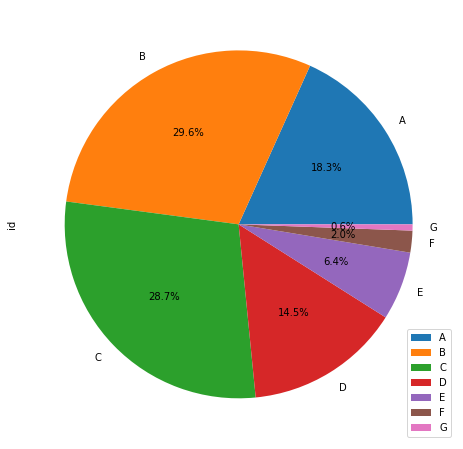

In [ ]:
plot = df.groupby('grade').count().plot.pie(y='id', autopct='%1.1f%%', figsize=(8,8))

In [1]:
# Success rate of loans by grade.
df.groupby('grade')['loan_status'].sum()/df.groupby('grade')['loan_status'].count() 

NameError: ignored

In [ ]:
# Count of loans by grade.
df.groupby('grade')['loan_status'].count()

grade
A    331294
B    536076
C    521793
D    263908
E    115808
F     36779
G     10559
Name: loan_status, dtype: int64

In [5]:
# Avaliable capital for loans by grade.
test = df[df['issue_d']>=2017]
test.groupby('grade')['loan_amnt'].sum()

grade
A    1764071650
B    2330580625
C    2484159825
D    1217246250
E     432706400
F     132478175
G      68824575
Name: loan_amnt, dtype: int64

In [ ]:
# Interest rate of loans by grade.
df.groupby('grade')['int_rate'].mean()

grade
A    0.070729
B    0.106415
C    0.140758
D    0.179994
E    0.216336
F    0.254071
G    0.282122
Name: int_rate, dtype: float64

In [ ]:
# Average payout of loans by grade.
df.groupby('grade')['loan_status'].sum()/df.groupby('grade')['loan_status'].count() * df.groupby('grade')['int_rate'].sum()/df.groupby('grade')['int_rate'].count()

grade
A    0.066243
B    0.092190
C    0.109627
D    0.125924
E    0.135628
F    0.141567
G    0.143613
dtype: float64

In [ ]:
df.groupby('grade')['total_pymnt_inv'].sum()/df.groupby('grade')['loan_amnt'].sum()

grade
A    1.053904
B    1.062505
C    1.053554
D    1.041867
E    1.044183
F    1.020177
G    0.980219
dtype: float64

In [26]:
# This means that no matter the grade, all people who can't pay it off do so at the same rate.
# This can be that either frauds are the same or that employment issues/cashflow issues are the same. 
temp_df = df[df['loan_status']==0]
temp_df.groupby('grade')['total_pymnt_inv'].sum()/temp_df.groupby('grade')['loan_amnt'].sum()

grade
A    0.558954
B    0.573371
C    0.574955
D    0.577034
E    0.596540
F    0.593973
G    0.570274
dtype: float64

In [ ]:
temp_df = df[df['loan_status']==1]
temp_df.groupby('grade')['total_pymnt_inv'].sum()/temp_df.groupby('grade')['loan_amnt'].sum()

grade
A    1.088503
B    1.142734
C    1.199549
D    1.256832
E    1.323826
F    1.375743
G    1.378152
dtype: float64

In [ ]:
def plot_hist(df, grade):
  temp_df = df[df['loan_status']==0]
  temp_df = temp_df[temp_df['grade']==grade]
  print(temp_df['total_pymnt_inv'].sum()/temp_df['loan_amnt'].sum())
  plt.hist(temp_df['total_pymnt_inv']/temp_df['loan_amnt'], bins = 20);

0.5589540870466841


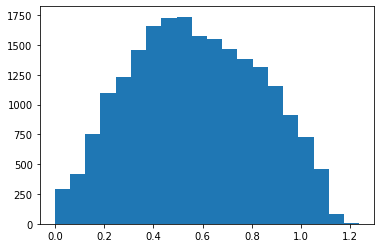

In [ ]:
plot_hist(df, 'A')

0.5733711211845731


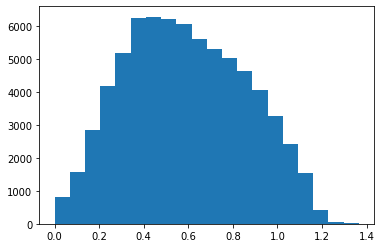

In [ ]:
plot_hist(df, 'B')

0.574954615078899


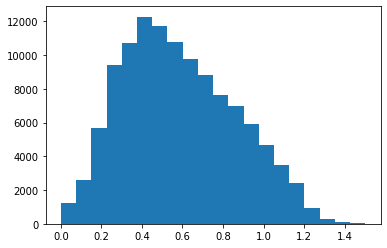

In [ ]:
plot_hist(df, 'C')

0.5770337921865698


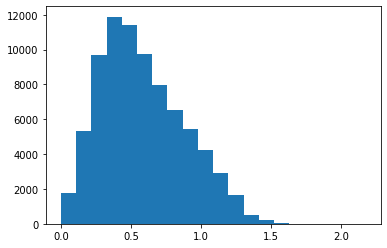

In [ ]:
plot_hist(df, 'D')

0.5965400447523279


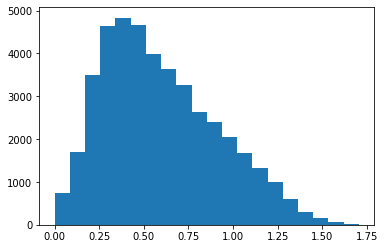

In [ ]:
plot_hist(df, 'E')

In [ ]:
df.groupby(['grade', 'term', 'home_ownership'])['total_pymnt_inv'].sum()/df.groupby(['grade', 'term', 'home_ownership'])['loan_amnt'].sum()

grade  term        home_ownership
A       36 months  MORTGAGE          1.059005
                   OWN               1.047397
                   RENT              1.047512
        60 months  MORTGAGE          1.056957
                   OWN               1.025394
                   RENT              0.982469
B       36 months  MORTGAGE          1.072647
                   OWN               1.056783
                   RENT              1.055029
        60 months  MORTGAGE          1.073353
                   OWN               1.034029
                   RENT              1.013132
C       36 months  MORTGAGE          1.068626
                   OWN               1.048565
                   RENT              1.041152
        60 months  MORTGAGE          1.075484
                   OWN               1.027698
                   RENT              1.006857
D       36 months  MORTGAGE          1.056253
                   OWN               1.037443
                   RENT              1.024908


In [ ]:
df.groupby(['grade', 'term'])['total_pymnt_inv'].sum()/df.groupby(['grade', 'term'])['loan_amnt'].sum()

In [ ]:
df.groupby(['grade', 'home_ownership'])['total_pymnt_inv'].sum()/df.groupby(['grade', 'home_ownership'])['loan_amnt'].sum()

In [ ]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)



test.groupby(['grade', 'issue_d'])['loan_status'].sum()/test.groupby(['grade', 'issue_d'])['loan_status'].count()

grade  issue_d
A      2012       0.944206
       2013       0.962312
       2014       0.957529
       2015       0.963190
       2016       0.958793
       2017       0.948571
       2018       0.935185
B      2012       0.854722
       2013       0.920362
       2014       0.913380
       2015       0.899748
       2016       0.889293
       2017       0.896057
       2018       0.863636
C      2012       0.831502
       2013       0.829854
       2014       0.845485
       2015       0.844539
       2016       0.822410
       2017       0.838738
       2018       0.776245
D      2012       0.765363
       2013       0.796296
       2014       0.790526
       2015       0.755660
       2016       0.731870
       2017       0.748344
       2018       0.759259
E      2012       0.670886
       2013       0.790244
       2014       0.755149
       2015       0.702811
       2016       0.663594
       2017       0.700581
       2018       0.635135
F      2012       0.657895
       2013  